In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
import matplotlib
from matplotlib import pyplot as plt

In [11]:
import sys
import os

NOTEBOOK_DIR = os.path.dirname(os.path.realpath('__file__'))
NOTEBOOK_DIR_PARENT = os.path.dirname(NOTEBOOK_DIR)
sys.path.append(NOTEBOOK_DIR_PARENT)
NOTEBOOK_DIR_PARENT

'/home/shubham/Documents/study/2022SS/CIL/project/cil_project'

In [12]:
def resolve_device(key=None):
    """
    Returns `device name` to be used. (`key` will be used to 
    resolve device name based on usage group, in case different device 
    is required for diffrerent purposes. Currently it is
    being ignored)
    """
    default_device = "cuda" if torch.cuda.is_available() else "cpu"
    if key is not None:
        raise NotImplementedError()
    return default_device
    

In [25]:
class EdgeWeightingKernel(nn.Module):
    def __init__(self, edge_weight_factor=10, num_channels=1, device=resolve_device()) -> None:
        """
        `edge_weight_factor` controls the weight given to edges as follows:
        `final_weight` = `normalized_edge_map`*`edge_weight_factor` + 1.0
        """
        super().__init__()
        self.num_channels = num_channels
        self.device = device
        self.edge_weight_factor = edge_weight_factor
        self._init_edge_kernel()
        
    def forward(self, img):
        """
        Applies a 3 x 3 edge detection kernel
        to `img`. `img` must have shape like: (Batch, num_channels, H, W).
        """
        with torch.no_grad():
            edge_map =  F.conv2d(img, self.edge_kernel)
            edge_map = torch.abs(edge_map)
            max_values = torch.amax(edge_map, dim=(2, 3), keepdim=True) # along 
            edge_map = edge_map/max_values
        
        return edge_map*self.edge_weight_factor + 1.0 # +1.0 for base map
        
    
    def _init_edge_kernel(self):
        kernel = torch.tensor(
            data=[[1,  2,  -1],
                  [2,  0, -2],
                  [1, -2, -1]],
            dtype=torch.float32, #TODO: take dtype from some central module/config
            device=self.device,
            requires_grad=False
        )
        self.edge_kernel = kernel.view(1, 1, 3, 3).repeat(1, self.num_channels, 1, 1)
        self.edge_kernel.requires_grad = False
        
        

In [26]:
from datautil import get_train_test_dataloaders

In [27]:
data_path = "/home/shubham/Documents/study/2022SS/CIL/project/cil_project/data/split"
train_dataloader, test_dataloader = get_train_test_dataloaders(data_path, shuffle=False)

In [28]:
x, y = None, None
for img, seg_map in test_dataloader:
    x = img
    y = seg_map
    break

In [29]:
edge_weight_layer = EdgeWeightingKernel()

In [30]:
edge_weight_map = edge_weight_layer(y)
test_image_index = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.)
tensor(0.0909)


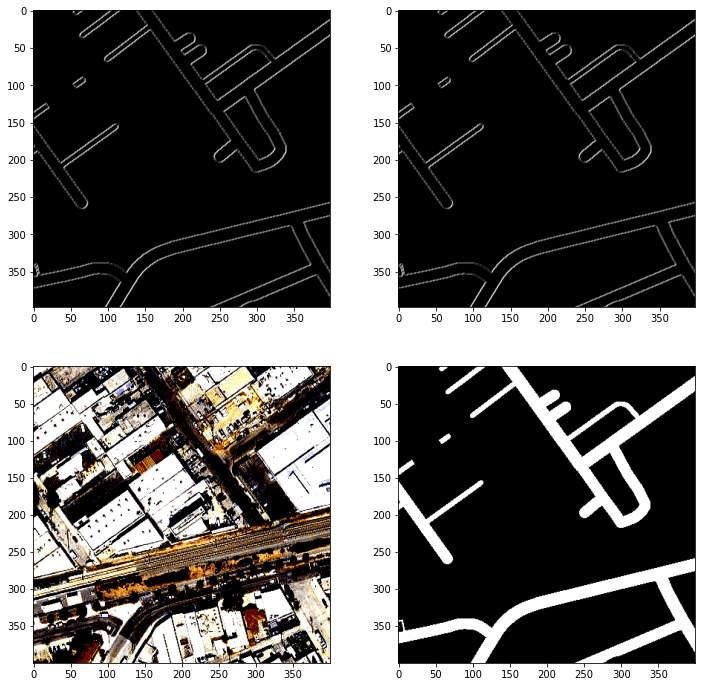

In [37]:



test_image, test_target = x[test_image_index], y[test_image_index]
pred = edge_weight_map[test_image_index] #model(test_image.unsqueeze(0).to('cuda'))[0]
pred_rounded = pred/torch.max(pred) #torch.where(pred>0.5, 1., 0.)
pred = pred_rounded
print(torch.max(pred))
print(torch.min(pred))

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
im = ax[0, 0].imshow(pred.squeeze(0).detach().cpu().numpy() * 255, cmap='gray')
im = ax[0, 1].imshow(pred_rounded.squeeze(0).detach().cpu().numpy() * 255, cmap='gray')
im = ax[1, 0].imshow(test_image.permute(1, 2, 0).detach().cpu().numpy())
im = ax[1, 1].imshow(test_target[0].detach().cpu().numpy() * 255, cmap='gray')

plt.show()
test_image_index += 1

In [40]:
edge_weight_layer_3ch = EdgeWeightingKernel(num_channels=3)
edge_weight_map_3ch = edge_weight_layer_3ch(x)
test_image_index_3ch = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.)
tensor(0.0909)


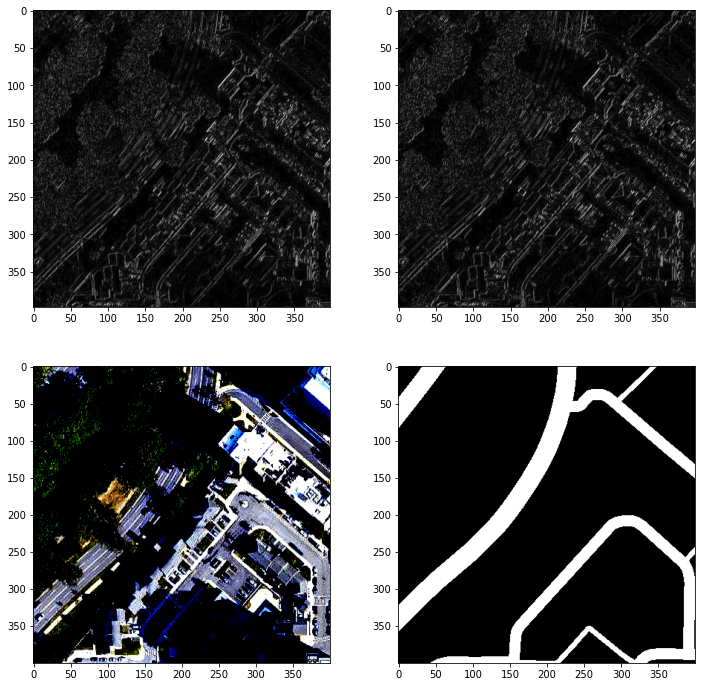

In [41]:
test_image, test_target = x[test_image_index], y[test_image_index]
pred = edge_weight_map_3ch[test_image_index] #model(test_image.unsqueeze(0).to('cuda'))[0]
pred_rounded = pred/torch.max(pred) #torch.where(pred>0.5, 1., 0.)
pred = pred_rounded
print(torch.max(pred))
print(torch.min(pred))

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
im = ax[0, 0].imshow(pred.squeeze(0).detach().cpu().numpy() * 255, cmap='gray')
im = ax[0, 1].imshow(pred_rounded.squeeze(0).detach().cpu().numpy() * 255, cmap='gray')
im = ax[1, 0].imshow(test_image.permute(1, 2, 0).detach().cpu().numpy())
im = ax[1, 1].imshow(test_target[0].detach().cpu().numpy() * 255, cmap='gray')

plt.show()

# if channel_num
test_image_index_3ch += 1